In [27]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math


In [7]:
from datetime import datetime

# Update the dateparse function for the format 'dd-mm-yy'
dateparse = lambda dates: datetime.strptime(dates, '%d-%m-%y')
df = pd.read_csv('daily_wholesale_price_Wheat-upto_apr_2015.csv', index_col='Date', parse_dates=['Date'], date_parser=dateparse)
df = df.dropna() 
# Group by 'Date' and compute the average Price
df = df.groupby('Date')['Price'].mean().reset_index()
print(df.shape)
df.head()

(1553, 2)


,Date,Price
0,2009-01-01,1172.857143
1,2009-01-02,1260.000000
2,2009-01-05,1200.000000
3,2009-01-06,1266.666667
4,2009-01-07,1200.000000


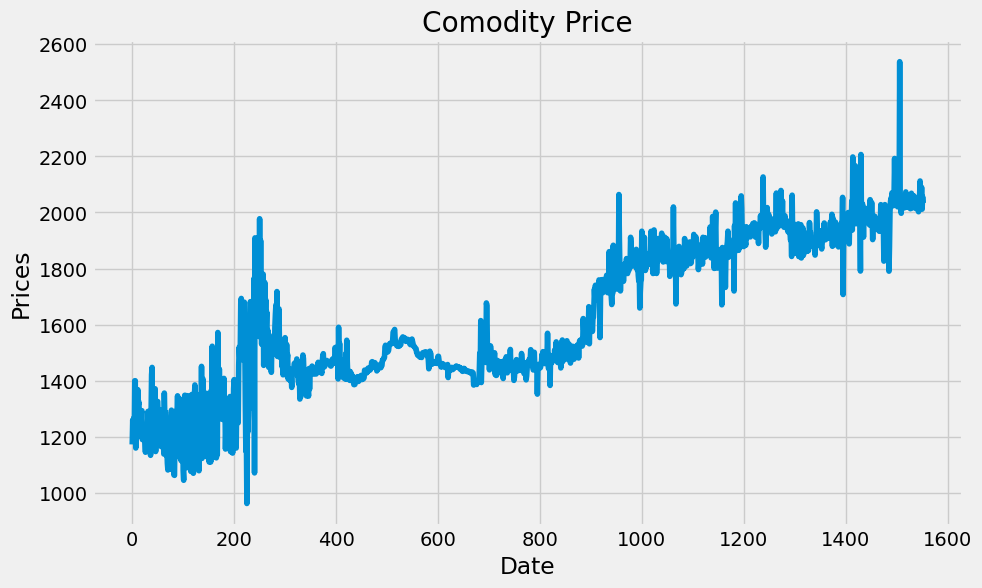

In [8]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Prices')
plt.plot(df['Price'])
plt.title('Comodity Price')
plt.show()

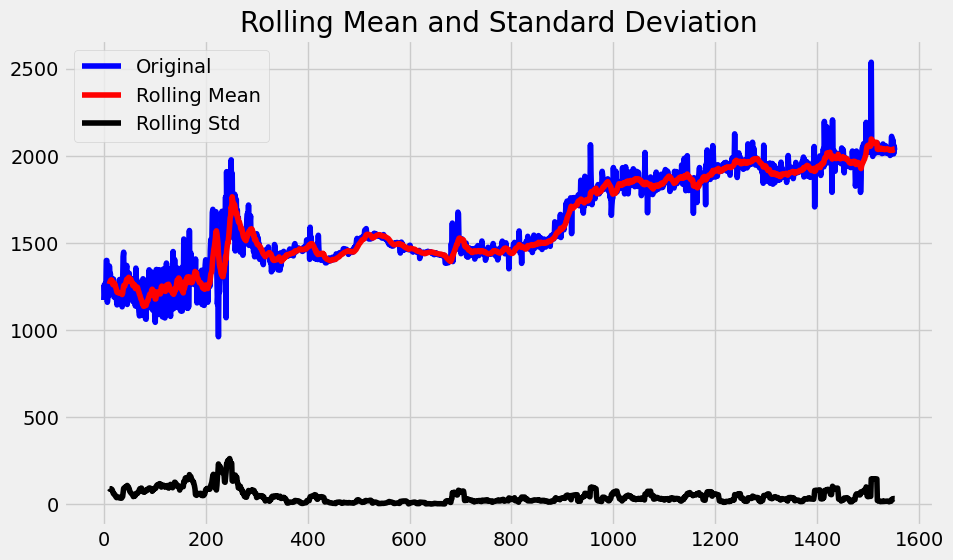

Results of Dickey-Fuller test:
Test Statistic                   -0.902806
p-value                           0.787047
No. of lags used                 18.000000
Number of observations used    1534.000000
critical value (1%)              -3.434620
critical value (5%)              -2.863426
critical value (10%)             -2.567774
dtype: float64


In [15]:
def test_stationarity(timeseries):
    # Determining rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    
    # Plot rolling statistics
    plt.figure(figsize=(10,6))
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show()
    
    # Perform Dickey-Fuller test
    print("Results of Dickey-Fuller test:")
    adft = adfuller(timeseries, autolag='AIC')
    
    # Create a pandas Series for the output of the test
    output = pd.Series(adft[0:4], index=['Test Statistic', 'p-value', 'No. of lags used', 'Number of observations used'])
    for key, value in adft[4].items():
        output[f'critical value ({key})'] = value
    print(output)

# Ensure you pass the numeric column to the function
test_stationarity(df['Price'])


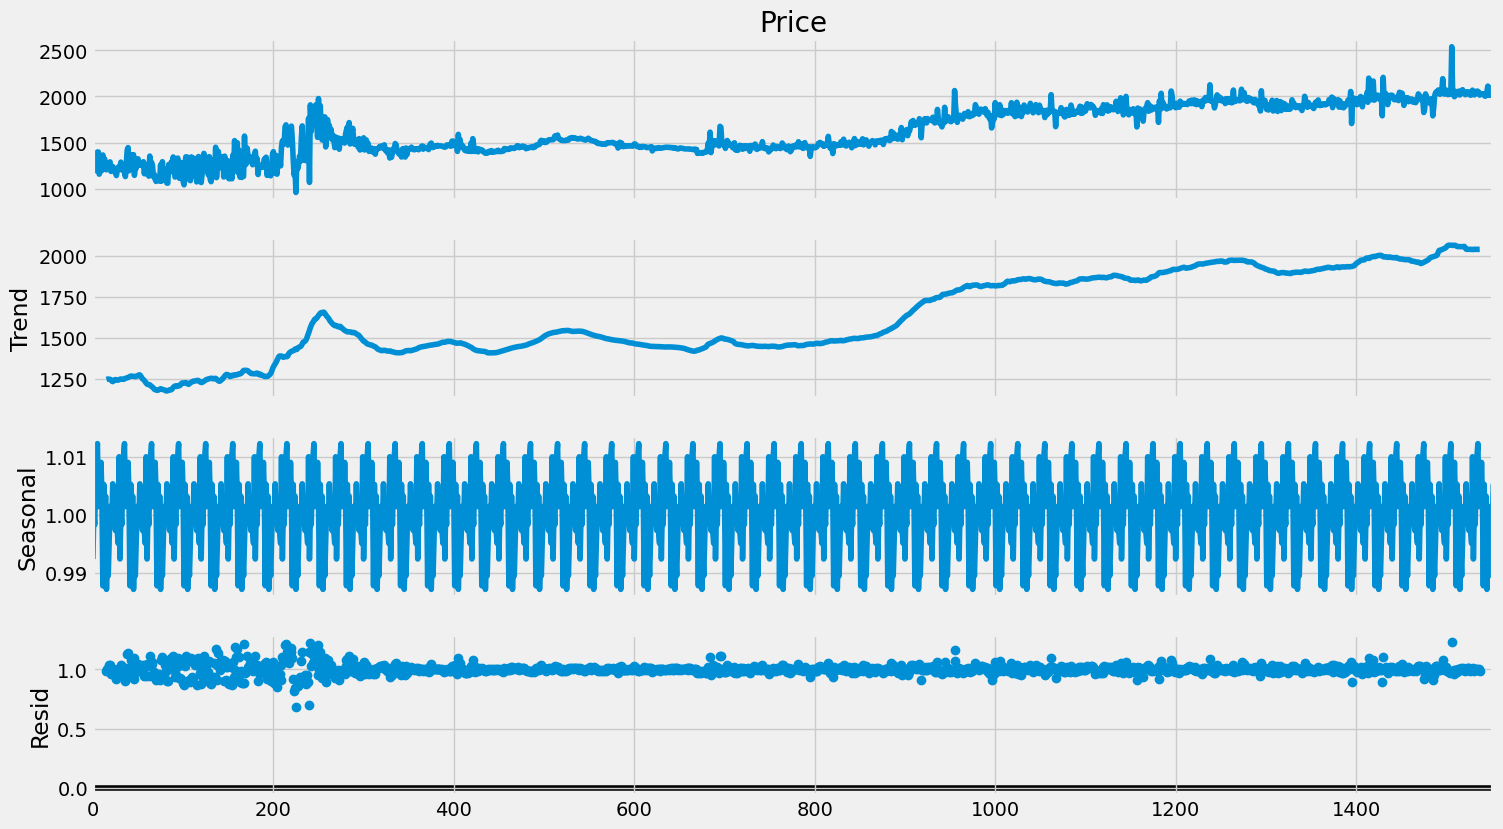

In [19]:
result = seasonal_decompose(df['Price'], model='multiplicative', period=30)

# Plot the results
fig = result.plot()
fig.set_size_inches(16, 9)
plt.show()

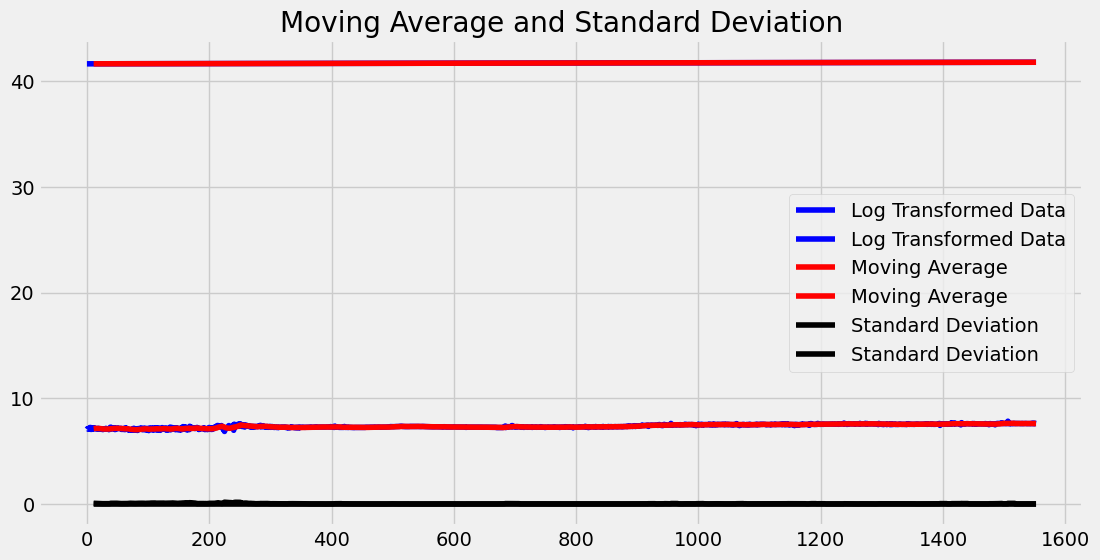

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Convert all values in the DataFrame to numeric, coercing non-numeric to NaN
df = df.apply(pd.to_numeric, errors='coerce')

# Handle NaN values - for example, you can fill them with the mean or drop them
df = df.fillna(df.mean())  # or df = df.dropna()

# Apply the log transformation
df_log = np.log(df)

# Calculate the moving average and standard deviation
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(df_log, label='Log Transformed Data', color='blue')
plt.plot(moving_avg, color='red', label='Moving Average')
plt.plot(std_dev, color='black', label='Standard Deviation')
plt.legend(loc='best')
plt.title('Moving Average and Standard Deviation')
plt.show()


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=16232.945, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=15729.212, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=15604.714, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16231.007, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=15601.609, Time=0.36 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=15569.768, Time=0.54 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=15665.822, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=15568.857, Time=0.69 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=15636.450, Time=0.11 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=15559.600, Time=0.91 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=15567.818, Time=0.91 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.74 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=15579.892, Time=1.55 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=15559.903, Time=0.58 sec

Best model:  ARIMA(3,1,2

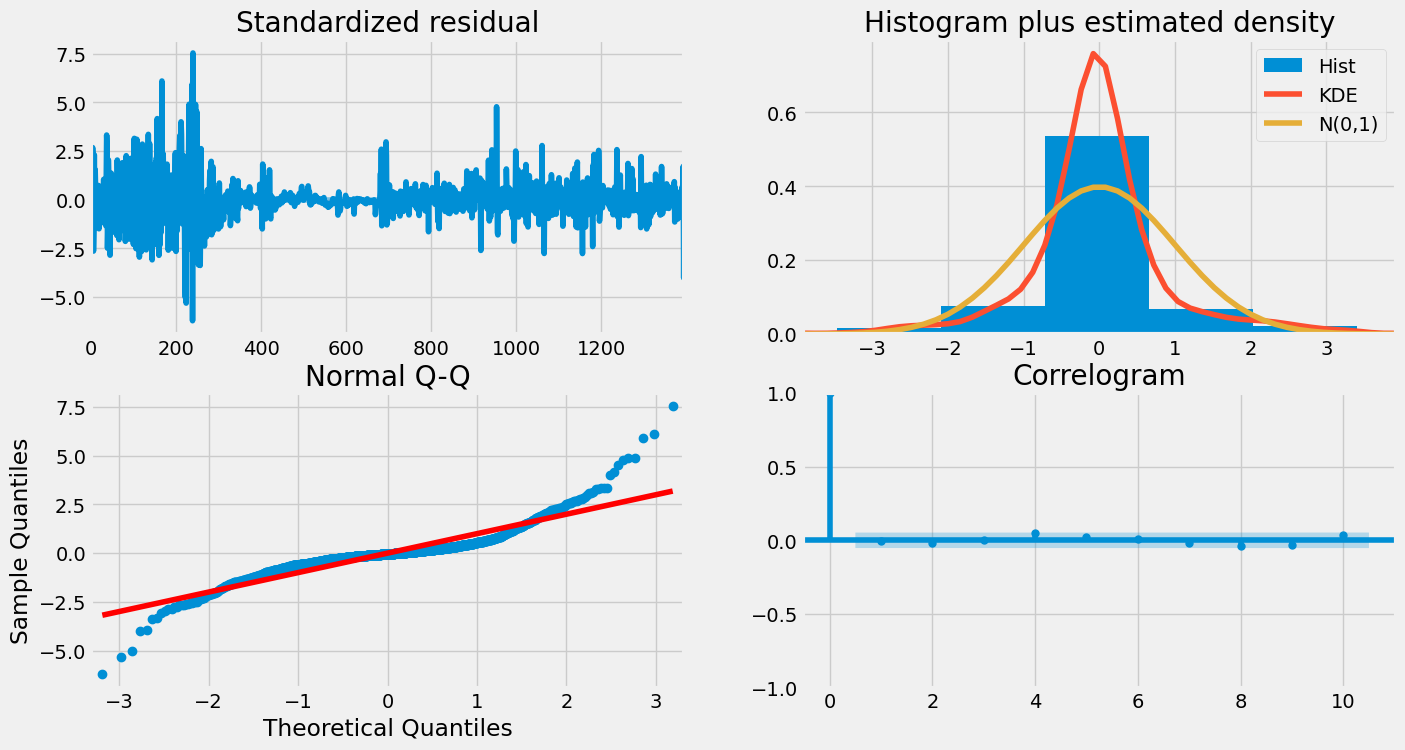

In [37]:
from pmdarima import auto_arima
import matplotlib.pyplot as plt

# Assuming 'Price' is the column you are interested in
df_log = df['Price']  # Use df['Price'] directly if it's already in log form

# Split the data
train_size = int(len(df_log) * 0.9)
train_data, test_data = df_log[:train_size], df_log[train_size:]

# Fit the auto_arima model with multiple processors
model_autoARIMA = auto_arima(
    train_data,
    start_p=0, 
    start_q=0,
    test='adf',       # use adftest to find optimal 'd'
    max_p=3, 
    max_q=3,         # maximum p and q
    m=1,              # frequency of series
    d=None,           # let model determine 'd'
    seasonal=False,   # No Seasonality
    start_P=0, 
    D=0, 
    trace=True,
    error_action='ignore',  
    suppress_warnings=True, 
    stepwise=True,
    n_jobs=-1         # Use all available processors
)

# Print summary
print(model_autoARIMA.summary())

# Plot diagnostics
model_autoARIMA.plot_diagnostics(figsize=(15, 8))
plt.show()


In [25]:
model_autoARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1397
Model:               SARIMAX(3, 0, 3)   Log Likelihood                2354.893
Date:                Sun, 08 Sep 2024   AIC                          -4695.786
Time:                        19:26:05   BIC                          -4659.092
Sample:                             0   HQIC                         -4682.067
                               - 1397                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9325      0.010    -97.177      0.000      -0.951      -0.914
ar.L2          0.9517      0.002    404.544      0.000       0.947       0.956
ar.L3          0.9808      0.010    100.077      0.000       0.962       1.000
ma.L1          1.2149      0.014     85.354      0.000       1.187       1.243
ma.L2         -0.3707      0.017    -21.455      0.000      -0.405      -0.337
ma.L3         -0.6640      0.016    -40.806      0.000      -0.696      -0.632
sigma2         0.0020    3.4e-05     58.843      0.000       0.002       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              6067.95
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.14   Skew:                             0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [38]:
model = ARIMA(train_data, order=(3,1,2))  
fitted = model.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                 1397
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -7773.951
Date:                Sun, 08 Sep 2024   AIC                          15559.903
Time:                        19:33:12   BIC                          15591.351
Sample:                             0   HQIC                         15571.660
                               - 1397                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8061      0.021    -37.692      0.000      -0.848      -0.764
ar.L2          0.3805      0.026     14.415      0.000       0.329       0.432
ar.L3          0.2733      0.017     16.289      0.0

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming `fitted` is your ARIMA model fitted object
forecast = fitted.get_forecast(steps=321)
forecast_df = forecast.summary_frame(alpha=0.05)

# Extracting forecasted values, standard errors, and confidence intervals
fc = forecast_df['mean']
conf_int = forecast_df[['mean_ci_lower', 'mean_ci_upper']]


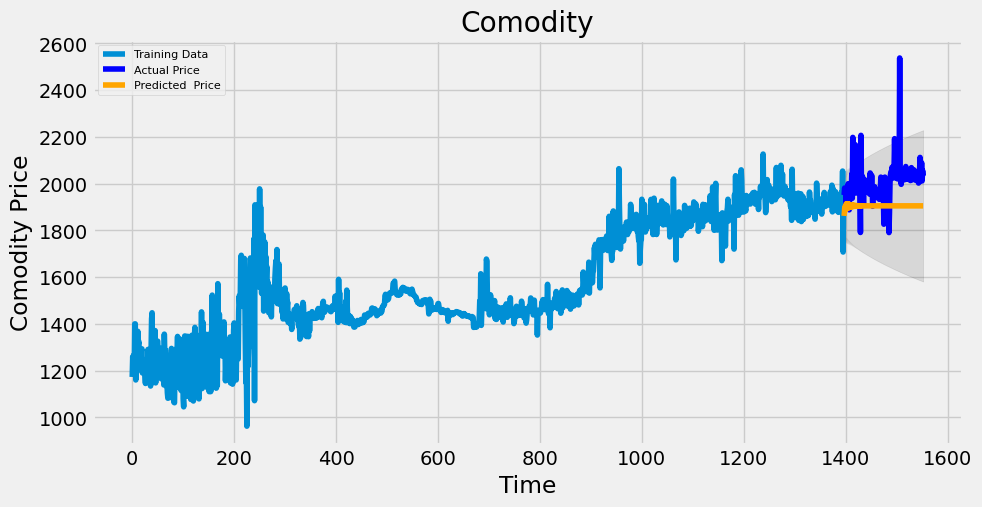

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming `fitted` is your ARIMA model fitted object
forecast = fitted.get_forecast(steps=len(test_data))
forecast_df = forecast.summary_frame(alpha=0.05)

# Extract forecast values and confidence intervals
fc_series = pd.Series(forecast_df['mean'].values, index=test_data.index)
lower_series = pd.Series(forecast_df['mean_ci_lower'].values, index=test_data.index)
upper_series = pd.Series(forecast_df['mean_ci_upper'].values, index=test_data.index)

# Plot
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(train_data, label='Training Data')
plt.plot(test_data, color='blue', label='Actual Price')
plt.plot(fc_series, color='orange', label='Predicted  Price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=0.1)
plt.title('Comodity')
plt.xlabel('Time')
plt.ylabel('Comodity Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()


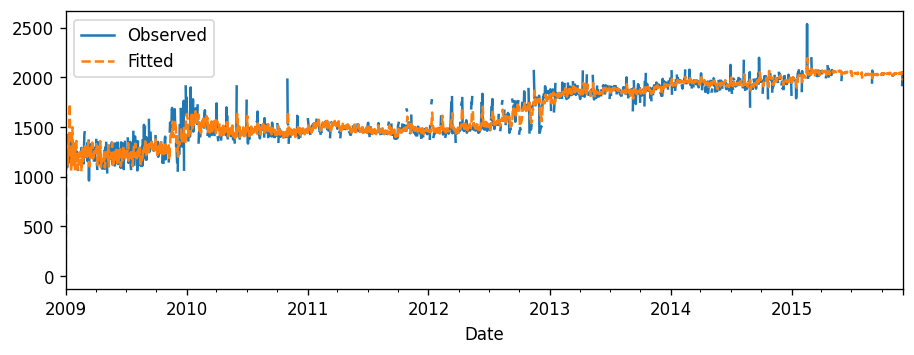

In [34]:
# Plot the results
df['Price'].plot(label='Observed')
model.fittedvalues.plot(label='Fitted', linestyle='--')

plt.legend()
plt.show()

In [47]:
from scipy import stats
df = df.dropna()
df["Price"],lmbda = stats.boxcox(df["Price"])

# Inverse Box-Cox Transformation Function
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

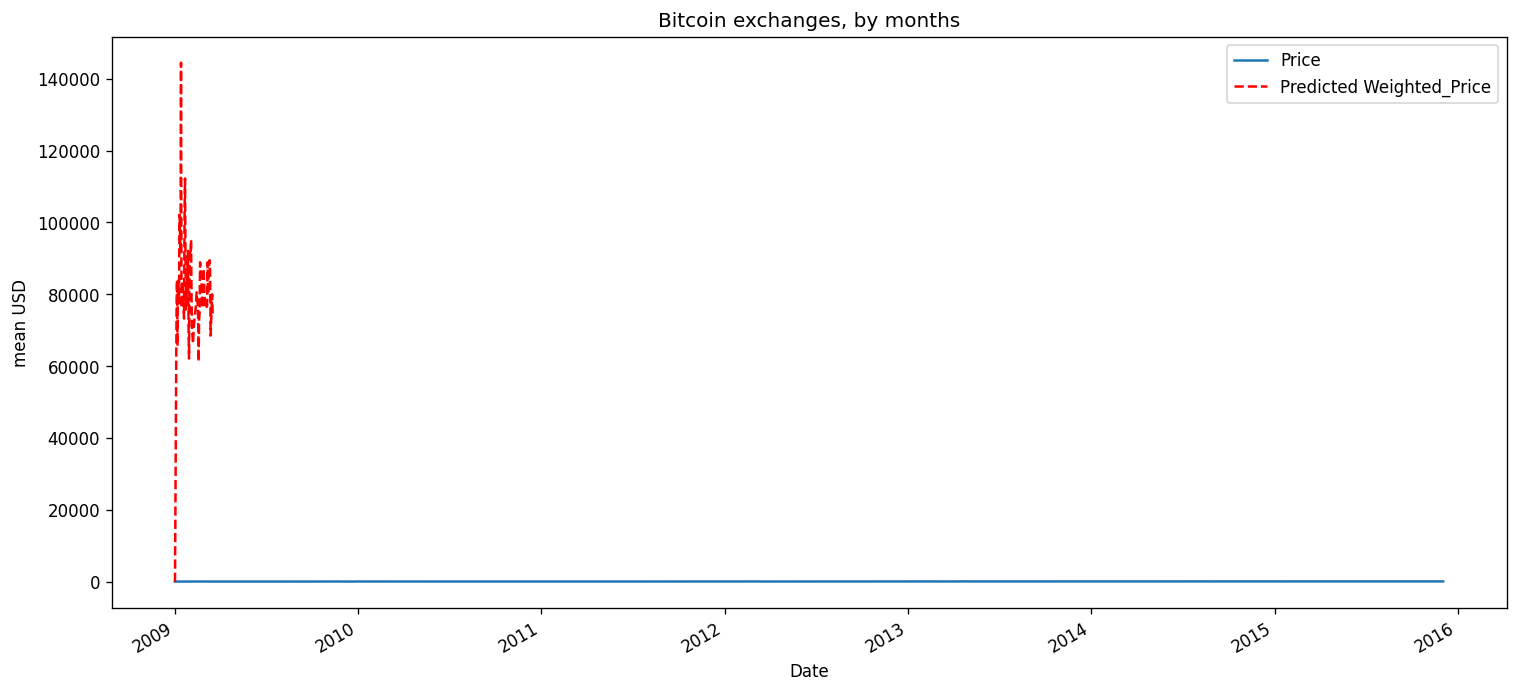

In [49]:
temp = df
temp['forecast'] = invboxcox(model.predict(start=0, end=75), lmbda)
plt.figure(figsize=(15,7))
temp["Price"].plot()
temp.forecast.plot(color='r', ls='--', label='Predicted Weighted_Price')
plt.legend()
plt.title('Bitcoin exchanges, by months')
plt.ylabel('mean USD')
plt.show()